In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import json
import numpy as np
from toolz import pluck

In [3]:
import algos
import features
import parametric
import policy
import chicken
from agents import OffPolicyAgent
from rlbench import *

In [4]:
def run_contextual(agent, env, max_steps, params=dict()):
    ret = list()
    
    # reset the environment, get initial state, perform the run
    t = 0
    env.reset()
    s = env.state
    while not env.is_terminal() and t < max_steps:
        actions = env.actions
        a = agent.choose(s, actions)
        r, sp = env.do(a)
        
        # update the agent
        agent.update(s, a, r, sp, **params)
        
        # get the information from the agent
        ret.append(agent.get_context(s, a, r, sp))
    
        # prepare for next timestep
        t += 1
        s = sp

    # return the result
    return ret 

# True Values

The "true" values can be computed analytically in this case, so we did so.

We can also compute the distribution for weighting the errors.

In [6]:
def compute_value_dct(theta_lst, features):
    return [{s: np.dot(theta, x) for s, x in features.items()} for theta in theta_lst]

def compute_values(theta_lst, X):
    return [np.dot(X, theta) for theta in theta_lst]

def compute_errors(value_lst, error_func):
    return [error_func(v) for v in value_lst]

def rmse_factory(true_values, d=None):
    true_values = np.ravel(true_values)
    
    # sensible default for weighting distribution
    if d is None:
        d = np.ones_like(true_values)
    else:
        d = np.ravel(d)
        assert(len(d) == len(true_values))
    
    # the actual root-mean square error
    def func(v):
        diff = true_values - v
        return np.sqrt(np.mean(d*diff**2))
    return func

# Comparing the Errors

For each algorithm, we get the associated experiment, and calculate the errors at each timestep, averaged over the runs performed with that algorithm.

In [19]:
# define the experiment
num_states = 8
num_features = 6
num_active = 3
num_runs = 10
max_steps = 10000


# set up environment
env = chicken.Chicken(num_states)

# Define the target policy
pol_pi = policy.FixedPolicy({s: {0: 1} for s in env.states})
# Define the behavior policy
pol_mu = policy.FixedPolicy({s: {0: 1} if s < 4 else {0: 0.5, 1: 0.5} for s in env.states})

# state-dependent gamma
gm_dct = {s: 0.9 for s in env.states}
gm_dct[0] = 0
gm_func = parametric.MapState(gm_dct)
gm_p_func = parametric.MapNextState(gm_dct)

# set up algorithm parameters
update_params = {
    'alpha': 0.02,
    'beta': 0.002,
    'gm': gm_func,
    'gm_p': gm_p_func,
    'lm': 0.0,
    'lm_p': 0.0,
    'interest': 1.0,
}


# Run all available algorithms 
data = dict()

for name, alg in algos.algo_registry.items():  
    print(name)
    
    run_lst = []
    for i in range(num_runs):
        print("Run: %d"%i, end="\r")
        episode_data = dict()
        
        # Want to use random features
        phi = features.RandomBinary(num_features, num_active)
        episode_data['features'] = {s: phi(s) for s in env.states}
    
        # Set up the agent
        _update_params = update_params.copy()
        if name == 'ETD':
            _update_params['alpha'] = 0.002

        agent = OffPolicyAgent(alg(phi.length), pol_pi, pol_mu, phi, _update_params)
        
        # Run the experiment
        episode_data['steps'] = run_contextual(agent, env, max_steps)
        
        run_lst.append(episode_data)
    data[name] = run_lst

TDC
GTD
TD
LSTD
GTD2
ETD


TDC


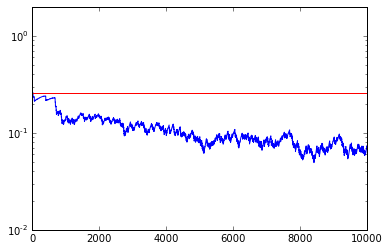

GTD


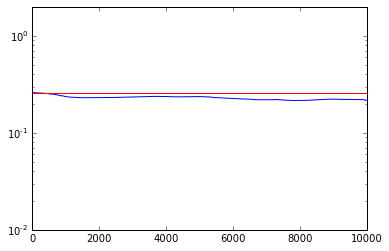

TD


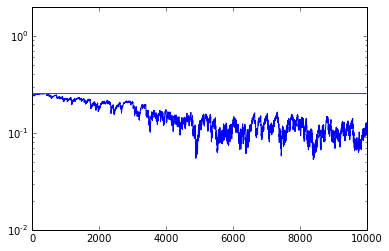

LSTD


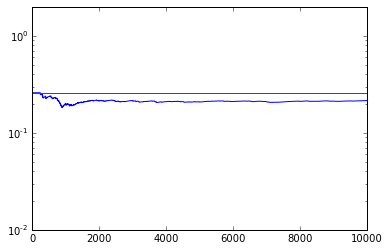

GTD2


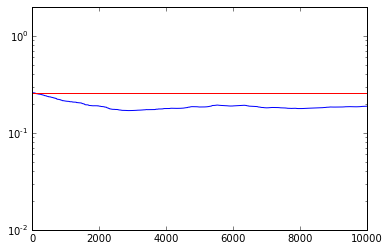

ETD


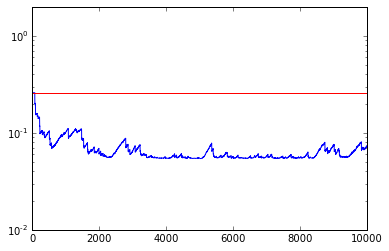

In [20]:
# True values & associated stationary distribution
theta_ls = np.array([ 0.4782969,  0.531441 , 0.59049, 0.6561, 0.729, 0.81, 0.9, 1.])
d_pi = np.ones(num_states)/num_states
D_pi = np.diag(d_pi)
    
# define the error/objective function
err_func = rmse_factory(theta_ls, d=d_pi)
baseline = err_func(np.zeros(num_states))

for name, experiment in data.items():
    print(name)
    errors = []
    for episode in experiment:
        feats = experiment[0]['features']
        X = np.array([feats[k] for k in sorted(feats.keys())])
        steps = experiment[0]['steps']
        thetas = list(pluck('theta', steps))

        # compute the values at each step
        val_lst = compute_values(thetas, X)
        # compute the errors at each step
        err_lst = compute_errors(val_lst, err_func)
        errors.append(err_lst)
    
    # calculate the average error
    clipped_errs = np.clip(errors, 0, 100) 
    avg_err = np.mean(clipped_errs, axis=0)
    
    # plot the errors 
    fig, ax = plt.subplots()
    ax.plot(avg_err)
    
    
    # format the graph
    ax.set_ylim(1e-2, 2)
    ax.axhline(baseline, c='red')
    
    ax.set_yscale('log')
    plt.show()